# Imports

In [47]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from keras.models import save_model
import keras
from keras.datasets import fashion_mnist
from keras.models import load_model
from keras.callbacks import TensorBoard

from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import UpSampling2D, Input, Reshape, Dense,Activation, Flatten, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, InputLayer
from keras import regularizers
from keras.callbacks import LearningRateScheduler
from keras.models import Model

%matplotlib inline

# Architecture Variables

In [48]:
bit_size = 512
architecture = '1024'
autoencoder_id='01'
model_path = F'models/bitsize{bit_size}/{architecture}architecture/'

# Load Data

In [49]:
class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)

In [50]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [51]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (60000, 28, 28) (60000,)
Test samples: (10000, 28, 28) (10000,)


In [52]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

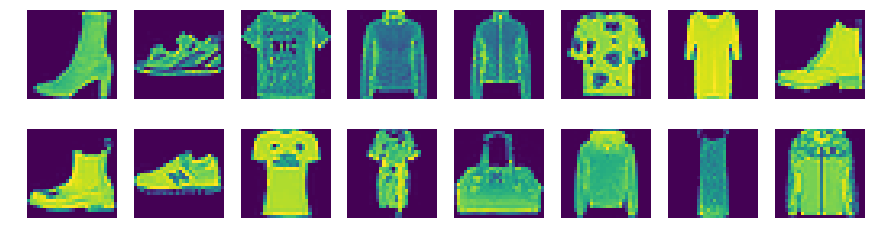

In [53]:

# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
#         ax.set_title(cifar10_classes[y_train[random_index, 0]])

In [54]:
x_train = x_train.reshape([-1, 28, 28, 1])
x_test = x_test.reshape([-1, 28, 28, 1])

IMG_SHAPE = x_train.shape[1:]

# center images
x_train = x_train.astype('float32') / 255.0 - 0.5
x_test = x_test.astype('float32') / 255.0 - 0.5

In [55]:
IMG_SHAPE

(28, 28, 1)

# Split Data

In [56]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(x_train,
                                                             x_train,
                                                             test_size=0.2,
                                                             random_state=13)

# Architecture

In [57]:
batch_size = 1000
epochs = 200
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

In [62]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32 256
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1) # 256
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [63]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = keras.optimizers.Adam(decay=1e-6))

In [64]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 28, 28, 256)       2560      
_________________________________________________________________
batch_normalization_57 (Batc (None, 28, 28, 256)       1024      
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 28, 28, 256)       590080    
_________________________________________________________________
batch_normalization_58 (Batc (None, 28, 28, 256)       1024      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 256)       0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 14, 14, 128)       295040    
__________

In [61]:
autoencoder_train = autoencoder.fit(train_X,
                                    train_ground,
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(valid_X, valid_ground)
                                   )

Train on 48000 samples, validate on 12000 samples
Epoch 1/200
48000/48000 [==============================] - 11s 239us/step - loss: 0.2848 - val_loss: 0.1749
Epoch 2/200
48000/48000 [==============================] - 10s 203us/step - loss: 0.1865 - val_loss: 0.1689
Epoch 3/200
48000/48000 [==============================] - 10s 204us/step - loss: 0.1677 - val_loss: 0.1680
Epoch 4/200
48000/48000 [==============================] - 10s 204us/step - loss: 0.1592 - val_loss: 0.1642
Epoch 5/200
48000/48000 [==============================] - 10s 204us/step - loss: 0.1550 - val_loss: 0.1603
Epoch 6/200
48000/48000 [==============================] - 10s 204us/step - loss: 0.1531 - val_loss: 0.1527
Epoch 7/200
48000/48000 [==============================] - 10s 205us/step - loss: 0.1515 - val_loss: 0.1509
Epoch 8/200
48000/48000 [==============================] - 10s 205us/step - loss: 0.1506 - val_loss: 0.1522
Epoch 9/200
48000/48000 [==============================] - 10s 205us/step - loss: 0.15

KeyboardInterrupt: 